## Imports

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
DEVICE = torch.device('cuda')
DEVICE

device(type='cuda')

In [3]:
%run ../utils/__init__.py

## Load data

In [4]:
%run ../datasets/__init__.py

### Load seg dataset

In [5]:
seg_dataloader = prepare_data_segmentation(dataset_name='jsrt', dataset_type='train')
len(seg_dataloader.dataset)

124

In [6]:
item = seg_dataloader.dataset[1]
item.image.size()

torch.Size([1, 512, 512])

In [7]:
item.image[0]

tensor([[-2.1756, -2.1756, -2.1756,  ..., -2.0608, -2.0608, -2.0608],
        [-2.1756, -2.1756, -2.1756,  ..., -2.0608, -2.0608, -2.0608],
        [-2.1756, -2.1756, -2.1756,  ..., -2.0608, -2.0608, -2.0752],
        ...,
        [ 0.4646,  1.4834,  1.4834,  ...,  1.4834,  1.4834,  1.4834],
        [ 0.4502,  1.4834,  1.4834,  ...,  1.4690,  1.4690,  1.4690],
        [ 0.4646,  1.4834,  1.4834,  ...,  1.4834,  1.4834,  1.4834]])

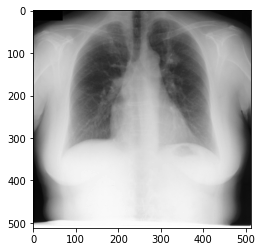

In [8]:
plt.imshow(item.image[0], cmap='gray')

### Load a classification dataset

In [9]:
kwargs = {
    'dataset_name': 'iu-x-ray',
    'dataset_type': 'train',
    'batch_size': 10,
    'image_format': 'L',
    'frontal_only': True,
    'norm_by_sample': True,
    'image_size': (1024, 1024),
}

dataloader = prepare_data_classification(**kwargs)
len(dataloader.dataset)

Loading iu-x-ray/train dataset...


3031

In [10]:
item = dataloader.dataset[1]
item.image.size()

torch.Size([1, 1024, 1024])

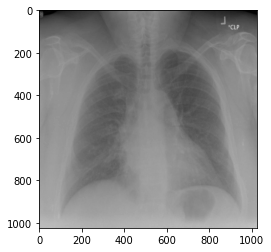

In [11]:
plt.imshow(item.image[0], cmap='gray')

## Load model

In [25]:
%run ../models/checkpoint/__init__.py

In [21]:
# run_name = '1105_180035_jsrt_scan_lr0.0001_normD_size1024'
run_name = '1106_092037_jsrt_scan_lr0.0001_normD_size1024'
debug = False

# run_name = '1106_165046_jsrt_scan_lr0.0001_normS_size1024_wce1-4-3-3'
# debug = True

In [26]:
compiled_model = load_compiled_model_segmentation(run_name, debug=debug, device=DEVICE)
compiled_model.metadata

{'model_kwargs': {'model_name': 'scan', 'n_classes': 4},
 'opt_kwargs': {'lr': 0.0001},
 'hparams': {'loss_weights': [0.1, 0.4, 0.3, 0.3],
  'early_stopping': True,
  'early_stopping_kwargs': {'patience': 1, 'metric': 'iou'}},
 'dataset_kwargs': {'dataset_name': 'jsrt',
  'batch_size': 20,
  'image_size': [1024, 1024],
  'num_workers': 2,
  'norm_by_sample': True},
 'dataset_train_kwargs': {'shuffle': None}}

## Examples

In [79]:
# item = seg_dataloader.dataset[8]
item = dataloader.dataset[2]

In [80]:
images = item.image.unsqueeze(0).to(DEVICE)

with torch.no_grad():
    outputs = compiled_model.model(images)

outputs = outputs.squeeze(0)
_, outputs = outputs.max(dim=0)
outputs = outputs.detach().cpu().numpy()

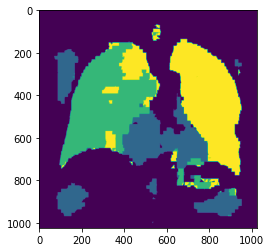

In [81]:
plt.imshow(outputs)